In [60]:
"""
Try to visualise what is going on with adverserial examples in 2d. Using tf is 
overkill for this but it lets me reuse my code easily
"""
%matplotlib notebook
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model, save_model
from keras import backend as K
import itertools as itr
from cleverhans.attacks_tf import fgm
import os
import argparse
import sys
sys.path.append('..')
from src.utilities import *
import scipy.special

This notebook is to try to visualise what is going on with the BALD and entropy of models on adverserial examples, hopefully to gain some intuition into what is going on, on a 2D toy dataset.

Note that in high dimensions, these blobs may not be a very faithful representation of the distribution of datapoints. In particular, there is the well known result that most of the volume of a high dimensional volume is concentrated in a thin shell near the surface; to see this, recall that a the n-ball of radius r

$$
\mathcal{B}^n = \{ x \in \mathbb{R}^n : \| x \|_2 \leq r \}
$$

has a volume $$V_{ball} =K(n) r^n$$ where $$K(n)$$ is a constant that depends on the dimensionality only. Now, consider the fraction of the volume of the sphere that is inside the shell close to the boundary

$$
\mathcal{S}^n = \{ x \in \mathbb{R}^n : c r \lt \| x \|_2 \leq r \} \; \text{where} \; c \in [0,1]
$$

The volume of this shell is given simply by
$$
V_{shell} = K(n) ( r^n - (c r)^n)
$$

and so the fraction of the volume of the ball that is in the shell is

$$
\frac{V_{shell}}{V_{ball}} = \frac{ r^n - (c r)^n} {r^n} = 1 - c^n
$$

That is, as 

$$n \to \infty,\;\frac{V_{shell}}{V_{ball}} \to 1$$

For example, in 1000 dimensional space, the fraction of the sphere that is within 0.01 r from the surface of the sphere is 0.999957. It is easy to show that a similar result holds for an n-cube. The relevance to adverserial examples is that, for any fixed partitioning of the feature space into decision cells, the majority of points are in some sense close to a boundary, so the two dimensional view we see below where most points are well within the interior of decision regions may be misleading

In [24]:
help(make_classification)

Help on function make_classification in module sklearn.datasets.samples_generator:

make_classification(n_samples=100, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    Generate a random n-class classification problem.
    
    This initially creates clusters of points normally distributed (std=1)
    about vertices of an `n_informative`-dimensional hypercube with sides of
    length `2*class_sep` and assigns an equal number of clusters to each
    class. It introduces interdependence between these features and adds
    various types of further noise to the data.
    
    Prior to shuffling, `X` stacks a number of these primary "informative"
    features, "redundant" linear combinations of these, "repeated" duplicates
    of sampled features, and arbitrary noise for and remaining features.
    
    Read more in the :ref:`Us

<IPython.core.display.Javascript object>


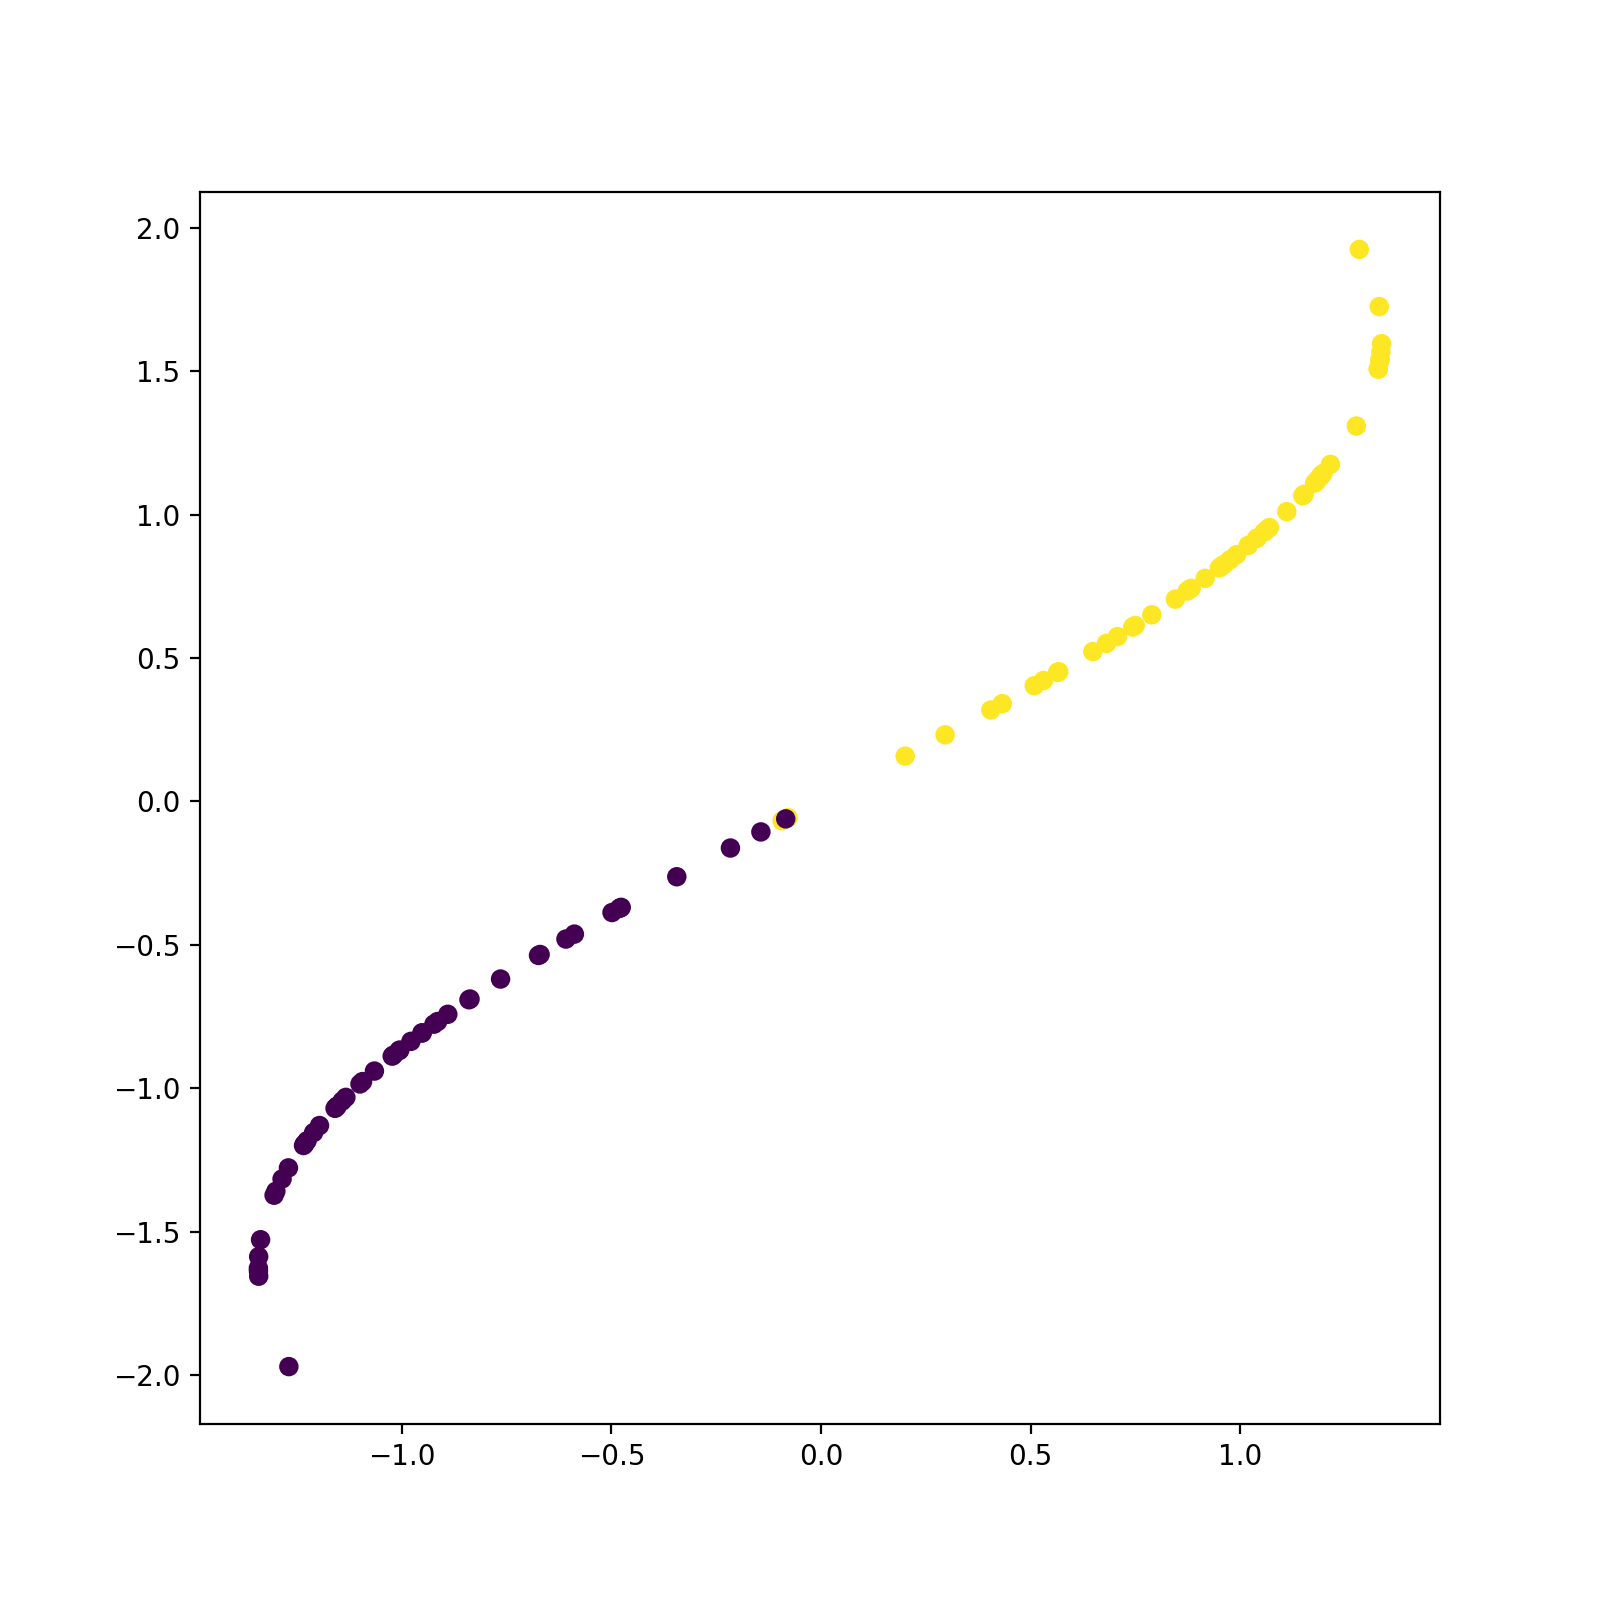

In [55]:
from sklearn.datasets import make_classification
N_c = 2 #number of classes
data,labels = make_classification(n_classes=N_c, n_features=2, n_redundant=1,n_informative=1, n_clusters_per_class=1, class_sep = 1)
data[:,0] = scipy.special.j1(data[:,0])
data -= data.mean(axis=0)
data /= data.std(axis=0)
plt.figure()
plt.scatter(data[:,0], data[:,1], c=labels)

In [49]:
help(keras.layers.Dropout)

Help on class Dropout in module keras.layers.core:

class Dropout(keras.engine.topology.Layer)
 |  Applies Dropout to the input.
 |  
 |  Dropout consists in randomly setting
 |  a fraction `rate` of input units to 0 at each update during training time,
 |  which helps prevent overfitting.
 |  
 |  # Arguments
 |      rate: float between 0 and 1. Fraction of the input units to drop.
 |      noise_shape: 1D integer tensor representing the shape of the
 |          binary dropout mask that will be multiplied with the input.
 |          For instance, if your inputs have shape
 |          `(batch_size, timesteps, features)` and
 |          you want the dropout mask to be the same for all timesteps,
 |          you can use `noise_shape=(batch_size, 1, features)`.
 |      seed: A Python integer to use as random seed.
 |  
 |  # References
 |      - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)
 |  
 |  Method 

In [56]:
#todo; put this in a file.

#The concrete dropout code was written by Yingzhen Li (MIT Licensed.): 
#source here https://github.com/YingzhenLi/Dropout_BBalpha/tree/concrete
import numpy as np
import keras.backend as K
from keras import initializers	# for Keras 2.0
#from keras import initializations as initializers	# for Keras 1.x.y
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper

class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        RandomUniform = initializers.RandomUniform	# for Keras 2.0
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        input_dim = np.prod(input_shape[1:])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        #print 'concrete dropout is called :)'
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
training=training)

In [58]:


K.set_learning_phase(True)
weight_decay = 0.001
inputs = keras.layers.Input(shape=(2,))

h1 = ConcreteDropout(Dense(1000, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(weight_decay)))(inputs)

h2 = ConcreteDropout(Dense(1000, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(weight_decay)))(h1)


predictions = ConcreteDropout(Dense(N_c, activation='softmax'))(h2)
model = keras.models.Model(inputs=inputs, outputs=predictions)

model.compile(
    optimizer='sgd',
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy'])

x = data
y = keras.utils.to_categorical(labels)
model.fit(x,y, epochs=100)


Epoch 1/100
100/100 [==============================] - 1s - loss: 1.6726 - acc: 0.6400     
Epoch 2/100
100/100 [==============================] - 0s - loss: 1.6385 - acc: 0.9100     
Epoch 3/100
100/100 [==============================] - 0s - loss: 1.6143 - acc: 0.9600     
Epoch 4/100
100/100 [==============================] - 0s - loss: 1.5864 - acc: 0.9800     
Epoch 5/100
100/100 [==============================] - 0s - loss: 1.5601 - acc: 0.9800     
Epoch 6/100
100/100 [==============================] - 0s - loss: 1.5339 - acc: 0.9800     
Epoch 7/100
100/100 [==============================] - 0s - loss: 1.5188 - acc: 0.9700     
Epoch 8/100
100/100 [==============================] - 0s - loss: 1.4932 - acc: 0.9800     
Epoch 9/100
100/100 [==============================] - 0s - loss: 1.4754 - acc: 0.9800     
Epoch 10/100
100/100 [==============================] - 0s - loss: 1.4633 - acc: 0.9600     
Epoch 11/100
100/100 [==============================] - 0s - loss: 1.4420 - acc

100/100 [==============================] - 0s - loss: 1.0764 - acc: 0.9800     
Epoch 89/100
100/100 [==============================] - 0s - loss: 1.0750 - acc: 0.9800     
Epoch 90/100
100/100 [==============================] - 0s - loss: 1.0673 - acc: 0.9900     
Epoch 91/100
100/100 [==============================] - 0s - loss: 1.0639 - acc: 0.9900     
Epoch 92/100
100/100 [==============================] - 0s - loss: 1.0670 - acc: 0.9800     
Epoch 93/100
100/100 [==============================] - 0s - loss: 1.0778 - acc: 0.9700     
Epoch 94/100
100/100 [==============================] - 0s - loss: 1.0786 - acc: 0.9700     
Epoch 95/100
100/100 [==============================] - 0s - loss: 1.0622 - acc: 0.9800     
Epoch 96/100
100/100 [==============================] - 0s - loss: 1.0720 - acc: 0.9800     
Epoch 97/100
100/100 [==============================] - 0s - loss: 1.0626 - acc: 0.9800     
Epoch 98/100
100/100 [==============================] - 0s - loss: 1.0724 - acc: 0.

In [61]:
#set up tensors to represent variables of interest
n_mc = 50

mc_preds_tensor = mc_dropout_preds(model, inputs, n_mc=n_mc)
entropy_mean_tensor = entropy_m(mc_preds_tensor)
bald_tensor = BALD(mc_preds_tensor)
mean_mc_preds = K.mean(mc_preds_tensor, axis=0)
mc_pred_class = K.one_hot(K.argmax(mean_mc_preds, axis=1), N_c) #current predicted class

loss_tensor = model.loss(mc_pred_class, mean_mc_preds) #loss of current predicted class
input_grad_tensor = K.gradients(loss_tensor, [inputs])
get_output = K.function([inputs], [K.mean(mc_preds_tensor, axis=0), 
                              entropy_mean_tensor,
                              bald_tensor,
                              input_grad_tensor[0]])

<IPython.core.display.Javascript object>


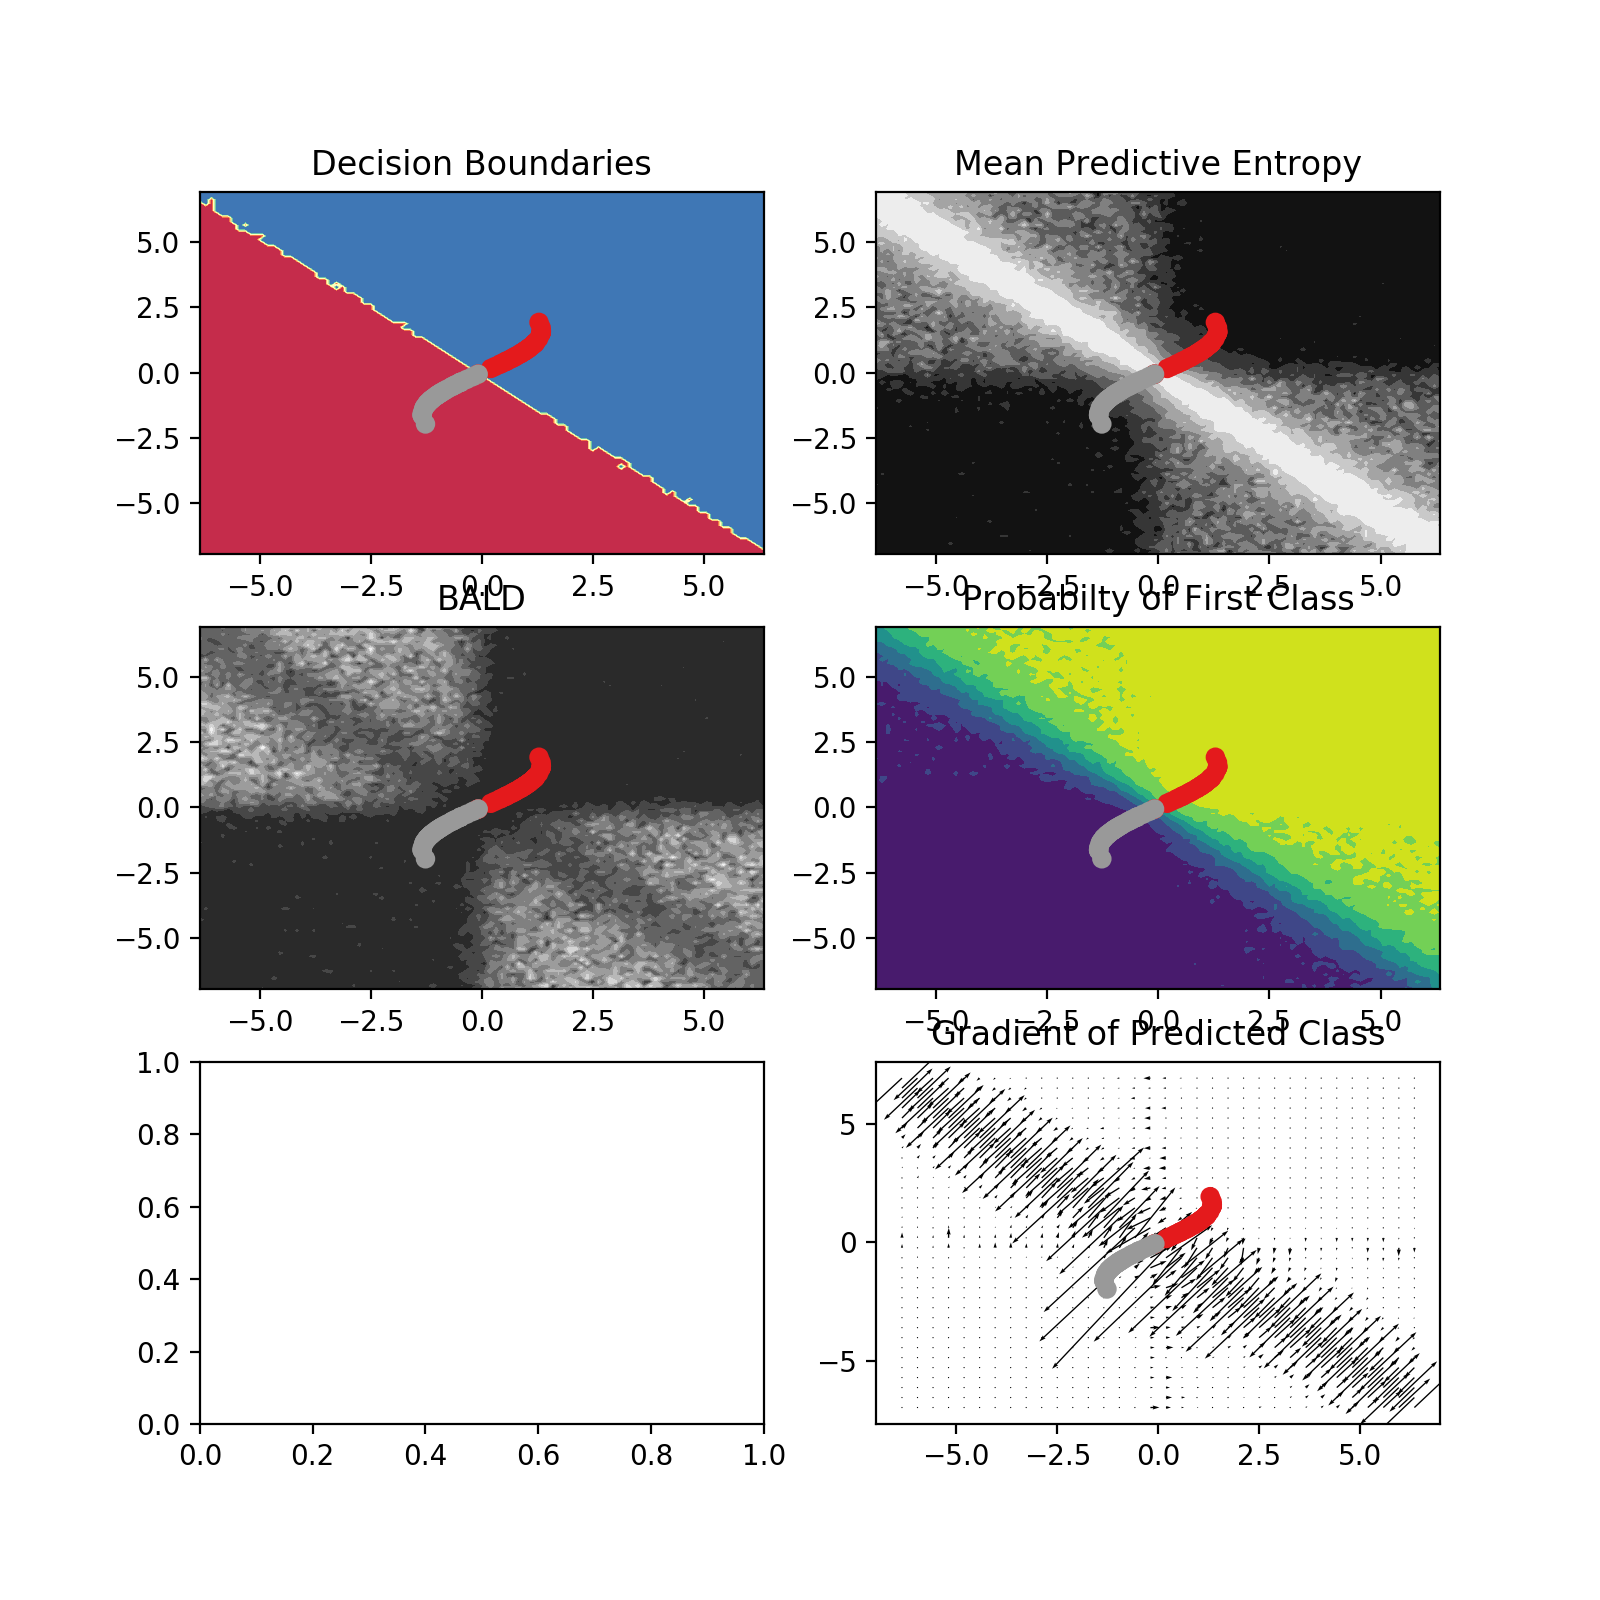

In [62]:
plt.rcParams['figure.figsize'] = 8,8
around = 5
xx,yy = np.meshgrid(np.linspace(data[:,0].min() -around,data[:,0].max() + around, 100),
                    np.linspace(data[:,1].min()-around,data[:,1].max()+around, 100))

plot_x = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)
plot_probs, plot_entropy, plot_bald, plot_grad = get_output([plot_x])
plot_preds = np.argmax(plot_probs, axis=1).reshape(xx.shape)

# plt.figure()
# plt.contourf(xx,yy,plot_decision_bounds, cmap=plt.cm.Set1)
# plt.scatter(data[:,0],data[:,1], c=labels, cmap=plt.cm.Set1_r); plt.show()

def mk_plots(xx, yy, x, y, probs, entropy, bald, grad):
    decision = probs.argmax(axis=1)
    
    f, ax = plt.subplots(3,2)
    backgrounds = [ decision, entropy , bald , probs[:,1]]
    titles = ['Decision Boundaries', 'Mean Predictive Entropy', 'BALD','Probabilty of First Class']
    backcols = [plt.cm.Spectral, plt.cm.gray, plt.cm.gray, plt.cm.viridis]
    axlist = [a for a in ax.flatten()]
    for (ax, field,c, title) in zip(axlist, backgrounds, backcols, titles):
        ax.contourf(xx,yy, field.reshape(xx.shape), cmap=c)
        ax.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.Set1_r)
        ax.set_title(title)
    
    grad_x = grad[:,0].reshape(xx.shape)
    grad_y = grad[:,1].reshape(xx.shape)
    
    #downsample for the quiver plot
    xx = xx[::3,::3]
    yy = yy[::3,::3]
    grad_x = grad_x[::3,::3]
    grad_y = grad_y[::3,::3]
    
    axlist[-1].quiver(xx,yy,grad_x, grad_y)
    axlist[-1].scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.Set1_r)
    axlist[-1].set_title('Gradient of Predicted Class')
mk_plots(xx,yy,data,labels,plot_probs,plot_entropy,plot_bald, plot_grad)

<IPython.core.display.Javascript object>


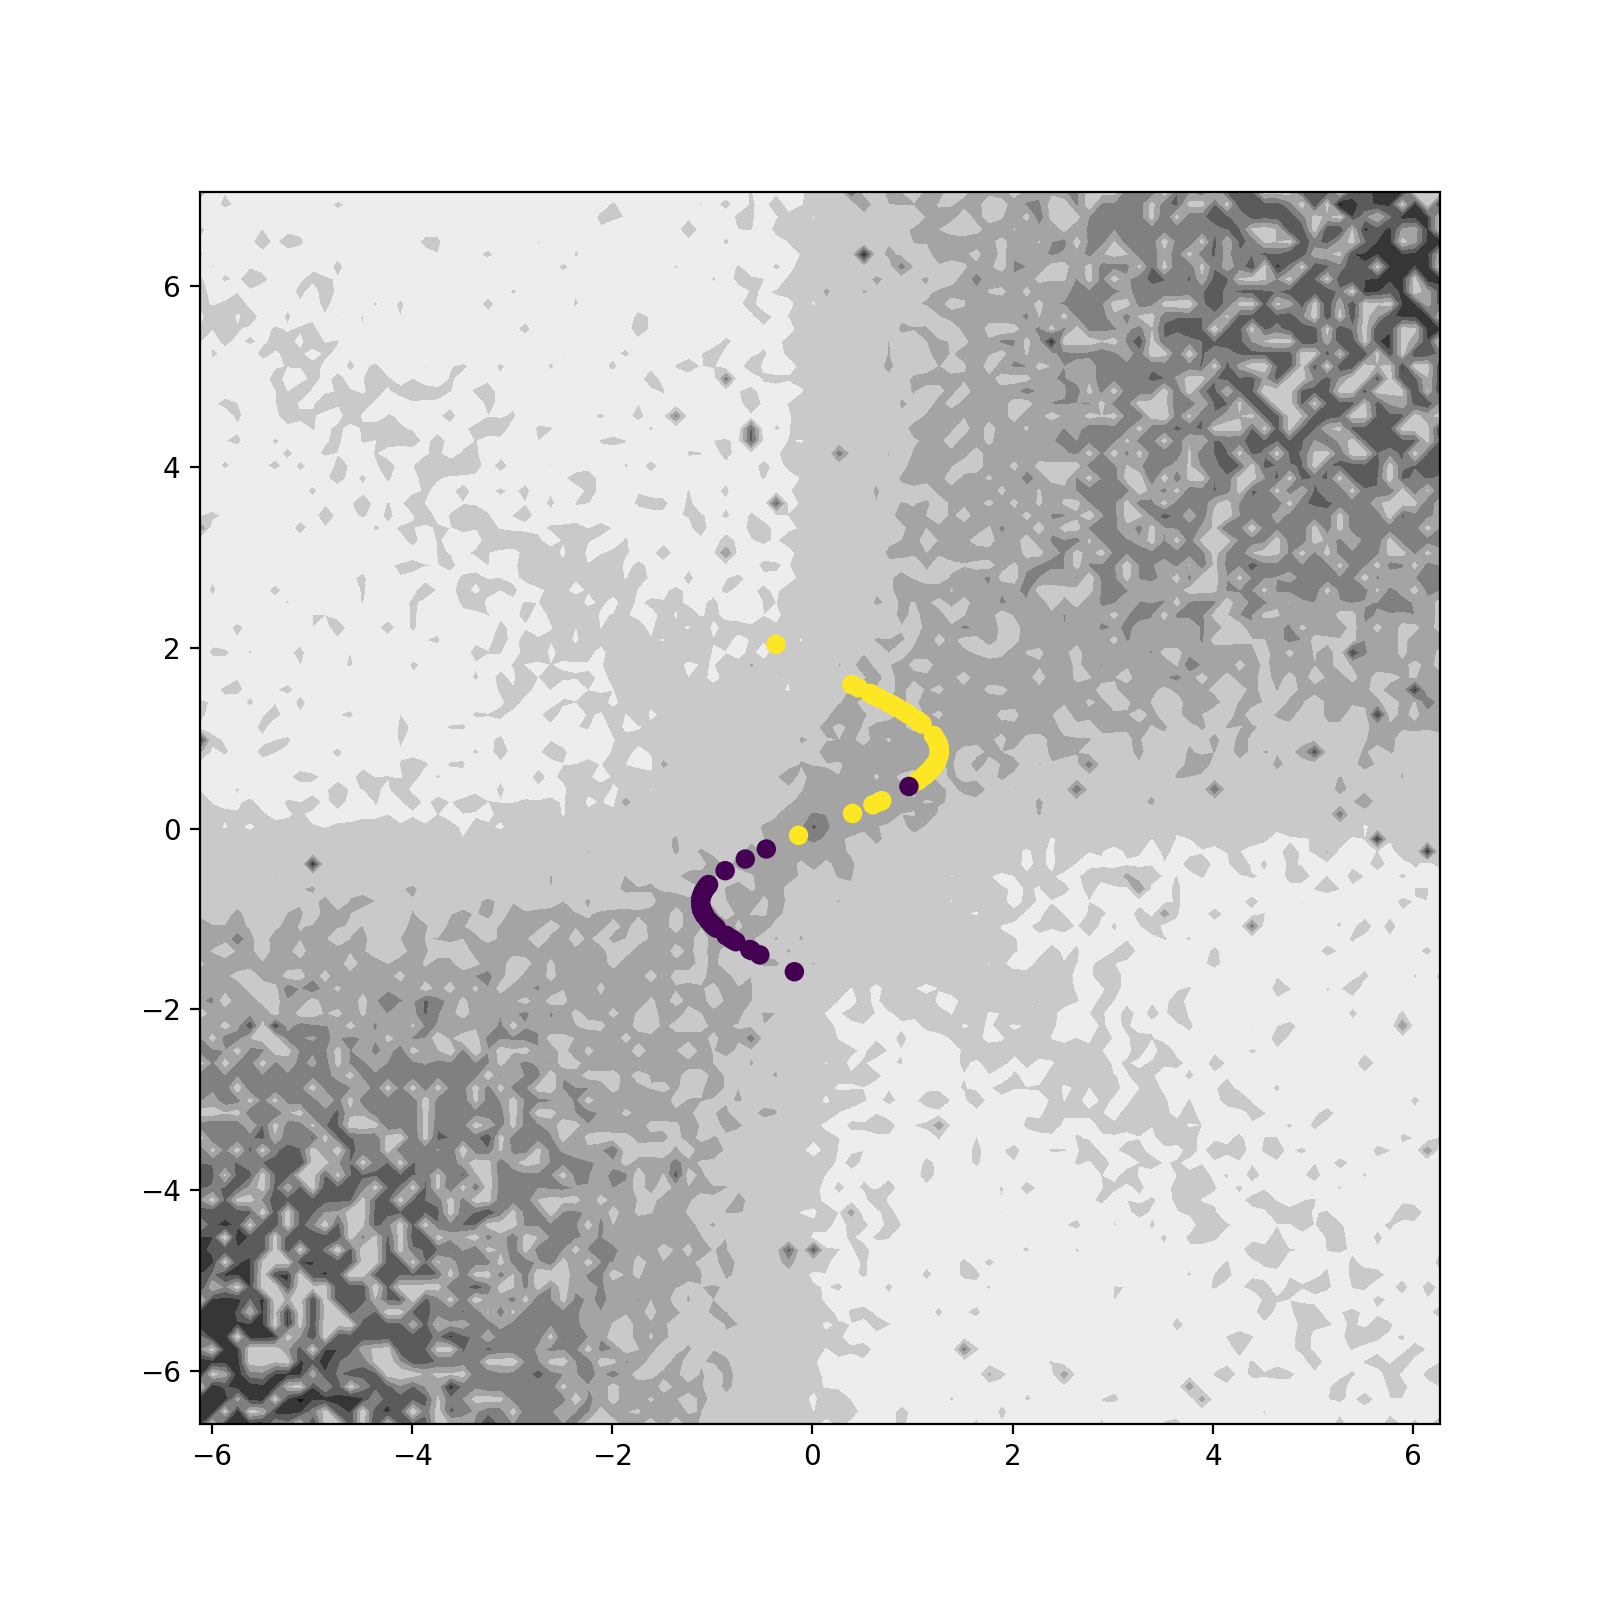

In [46]:
plt.figure()
plt.contourf(xx,yy,np.log(plot_bald.reshape(xx.shape) + 1e-6) , cmap = 'gray'); 
plt.scatter(data[:,0], data[:,1], c=labels)
plt.show()


The above plots show 4 characteristics of the output of the softmax layer of a neural network on this toy problem. The first shows the decision boundaries, which partition the data space into regions assigned to one of the three classes, choosing classes according to 

$$
\begin{align}
y_{predicted} &= \arg\max_{c} p(y_c \mid x, D) \\
              &= \arg\max_{c} \int p(y_c \mid \theta, x) p(\theta \mid D) d \theta \\
            &\simeq \arg\max_{c} \sum_{i=1}^{N_{mc}} p(y_c \mid x, \theta), \;\; \theta \sim q(\theta)
\end{align}
$$
where q is the (dropout) variational approximation to the true posterior over theta. Let us define
$$
p_{dropout}(y) := \sum_{i=1}^{N_{mc}} p(y_c \mid x, \theta), \;\; \theta \sim q(\theta)
$$
for the predictions of our model. The second two plots are two methods for evaluating the certainty of a classification model; the first is simply to look at the entropy 
$$
\text{H} = \sum_{x \in \mathcal{X}} p(x) \frac{1}{\log p(x)}
$$
of the predictive distribution. This is high when our predictive distribution spreads its mass uniformly over classes, and low when all the probability is concentrated in a single class. As can be seen above, this mostly recovers the area in the vicinity of the decision boundaries, since the predictive entropy is significant only when the softmax is non-saturating. The second measure is the 'BALD' (baysian active learning by disagreement) score, which was proposed initially as an aquisition function in reinforcement learning.
Recall that the _mutual information_ between two random variables X and Y is defined as 

$$
I(X,Y) = \text{H}(p(X)) - \mathbb{E}_{p(Y)}[ \text{H}(p(X \mid Y)) ]
$$

Now, consider the mutual information between the paramters and a new observation y, conditioned on the data and the input x;

$$
I(y, \theta \mid D, x) = \text{H}(p(y \mid D, x)) -  \mathbb{E}_{p(\theta \mid D, x)}[ \text{H}(p(y \mid x, \theta, D)) ]
$$

Consider the model parameters and D fixed and consider this as function of x only. What this function gives us is a measure of which values of x would provide the highest amount of information about the parameters if we had the correct output corresponding to x. Another way of stating this is that this function is high for x where we are uncertain about the model parameters (since these obtaining labels for these points would give us a high information gain).

This usefulness of this quantity as an aquisition function should be clear; now consider it as a measure of model uncertainty. Unlike the entropy, mutual information distinguishes between _aleatoric_ and _epistemic_ uncertainty. There are two reasons our predictive distribution may be uncertain; because our model parameters are poorly determined (epistemic) or because our data is inherently noisy (aleatoric). In the case of noisy data, even a very well determined model ought to have a high predictive entropy. On the other hand, for poorly determined parameters, many samples from the posterior over parameters will have low entropy, but the predictions will be different for different samples. The BALD score prefers epistemic uncertainty; in the case of a well determined model where the predictions have high entropy because of inherent stochasticity, the first term will be high, but cruicially the entropy will also be high for any sample from the parameter posterior, so it will be cancelled out by the second term. On the other hand, if the parameters are uncertain, the predictive distribution will still have high entropy, but any individual set of parameters is likely to have low entropy, so the second term will be small.

For the case of a dropout network, the expectations and integration over parameters in the calculation of the BALD score must be approximated by empirical means over samples from the variational distribution; it reduces to the difference between the entropy of the mean of these samples and the mean of the entropy. 

$$
BALD(x) = \text{H}(p_{dropout}(y)) - \frac{1}{N_{MC}} \sum_{i=1}^{N_{MC}} \text{H} (p(y_c \mid x, \theta)), \;\; \theta \sim q(\theta)
$$

The final panel shows the gradient of the cross entropy assuming that the current model classification is correct with respect to the input. That is, if 
$$
\hat{y} = \arg \max_c p_{dropout}(y_c)
$$
Then we plot 
$$
\nabla_{x} \mathcal{J}(\hat{y}, p_{dropout}(y_c))
$$
where 
$$
\mathcal{J}(y,y')
$$
is the cross entropy loss (in this case). This gives a direction in which the model's output is most sensitive to changes in the input. This gradient information is used by many adversarial example generation algorithms. The simplest one is the Fast Gradient Method, which takes a single step in the direction of this gradient.

These reveal some interesting properties in this 2D example. As might be expected, the entropy is high near the decision boundaries and low more or less everywhere else; this is likely because of the saturation of the softmax. The BALD score is less uniform; it is high only near decision boundaries that are far from the data. Notably, it is *not* high everywhere that is far from the data; this is a drawback, likely because our variational approximation only really explores close to a local mode; by eye, there are clearly ways of drawing decision planes that shatter the above dataset that are not explored by this approximation.

There may be a simple explanation for why entropy is often a better discriminator on FGM adversarial examples; as these show, the BALD score is strictly lower than the entropy of a MC dropout classifier

$$
BALD(x) = \text{H}(p_{dropout}(y)) - \mathbb{E}_{q(\theta)} \text{H} (p(y | \theta)) \leq \text{H}(p_{dropout}(y))
$$

since the entropy is positive semidefinite.

<IPython.core.display.Javascript object>


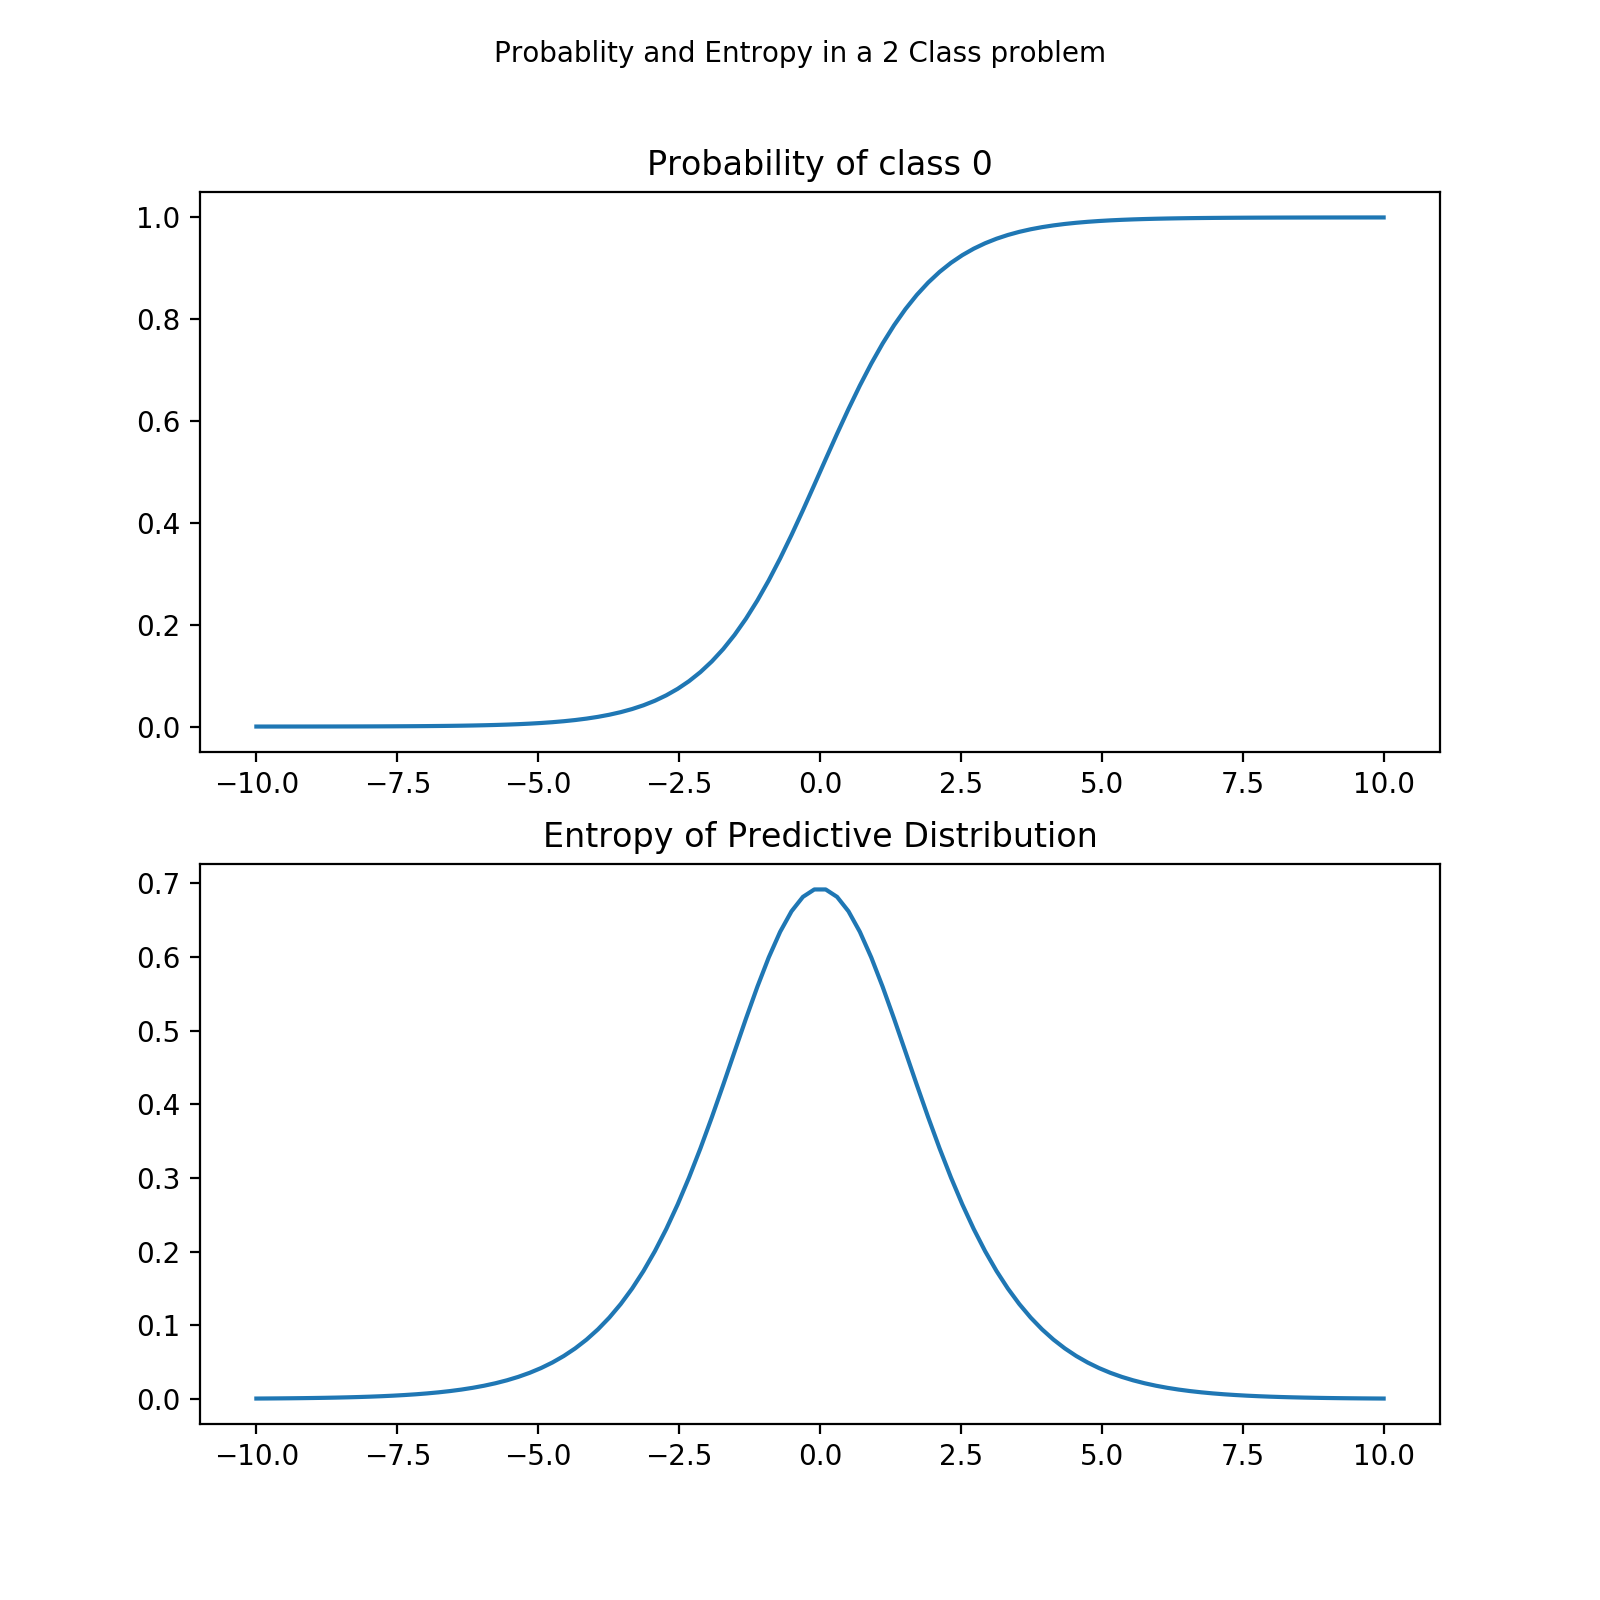

In [111]:
x = np.linspace(-10,10,100)
prob_x = 1 / (1 + np.exp(-x))
f, ax = plt.subplots(2,1)
ax[0].plot(x, prob_x)
ax[0].set_title('Probability of class 0')
entropy_x = - prob_x * np.log(prob_x) - (1 - prob_x) * np.log(1 - prob_x)
ax[1].plot(x,entropy_x)
ax[1].set_title('Entropy of Predictive Distribution')
f.text(0.5, 0.975, 'Probablity and Entropy in a 2 Class problem',
         horizontalalignment='center', verticalalignment='top')
plt.show()

TODO: is there a way to evaluate how much of the input space has a high gradient?? 
-> intuition; adv examples are hard when the gradient is small (see defensive distillation), though this is a somewhat limited approach.
-> second intuition;  gradient is high close to D.B's; according to the volume theorem above, this is the majority of the volume of the space in some sense? 

<IPython.core.display.Javascript object>


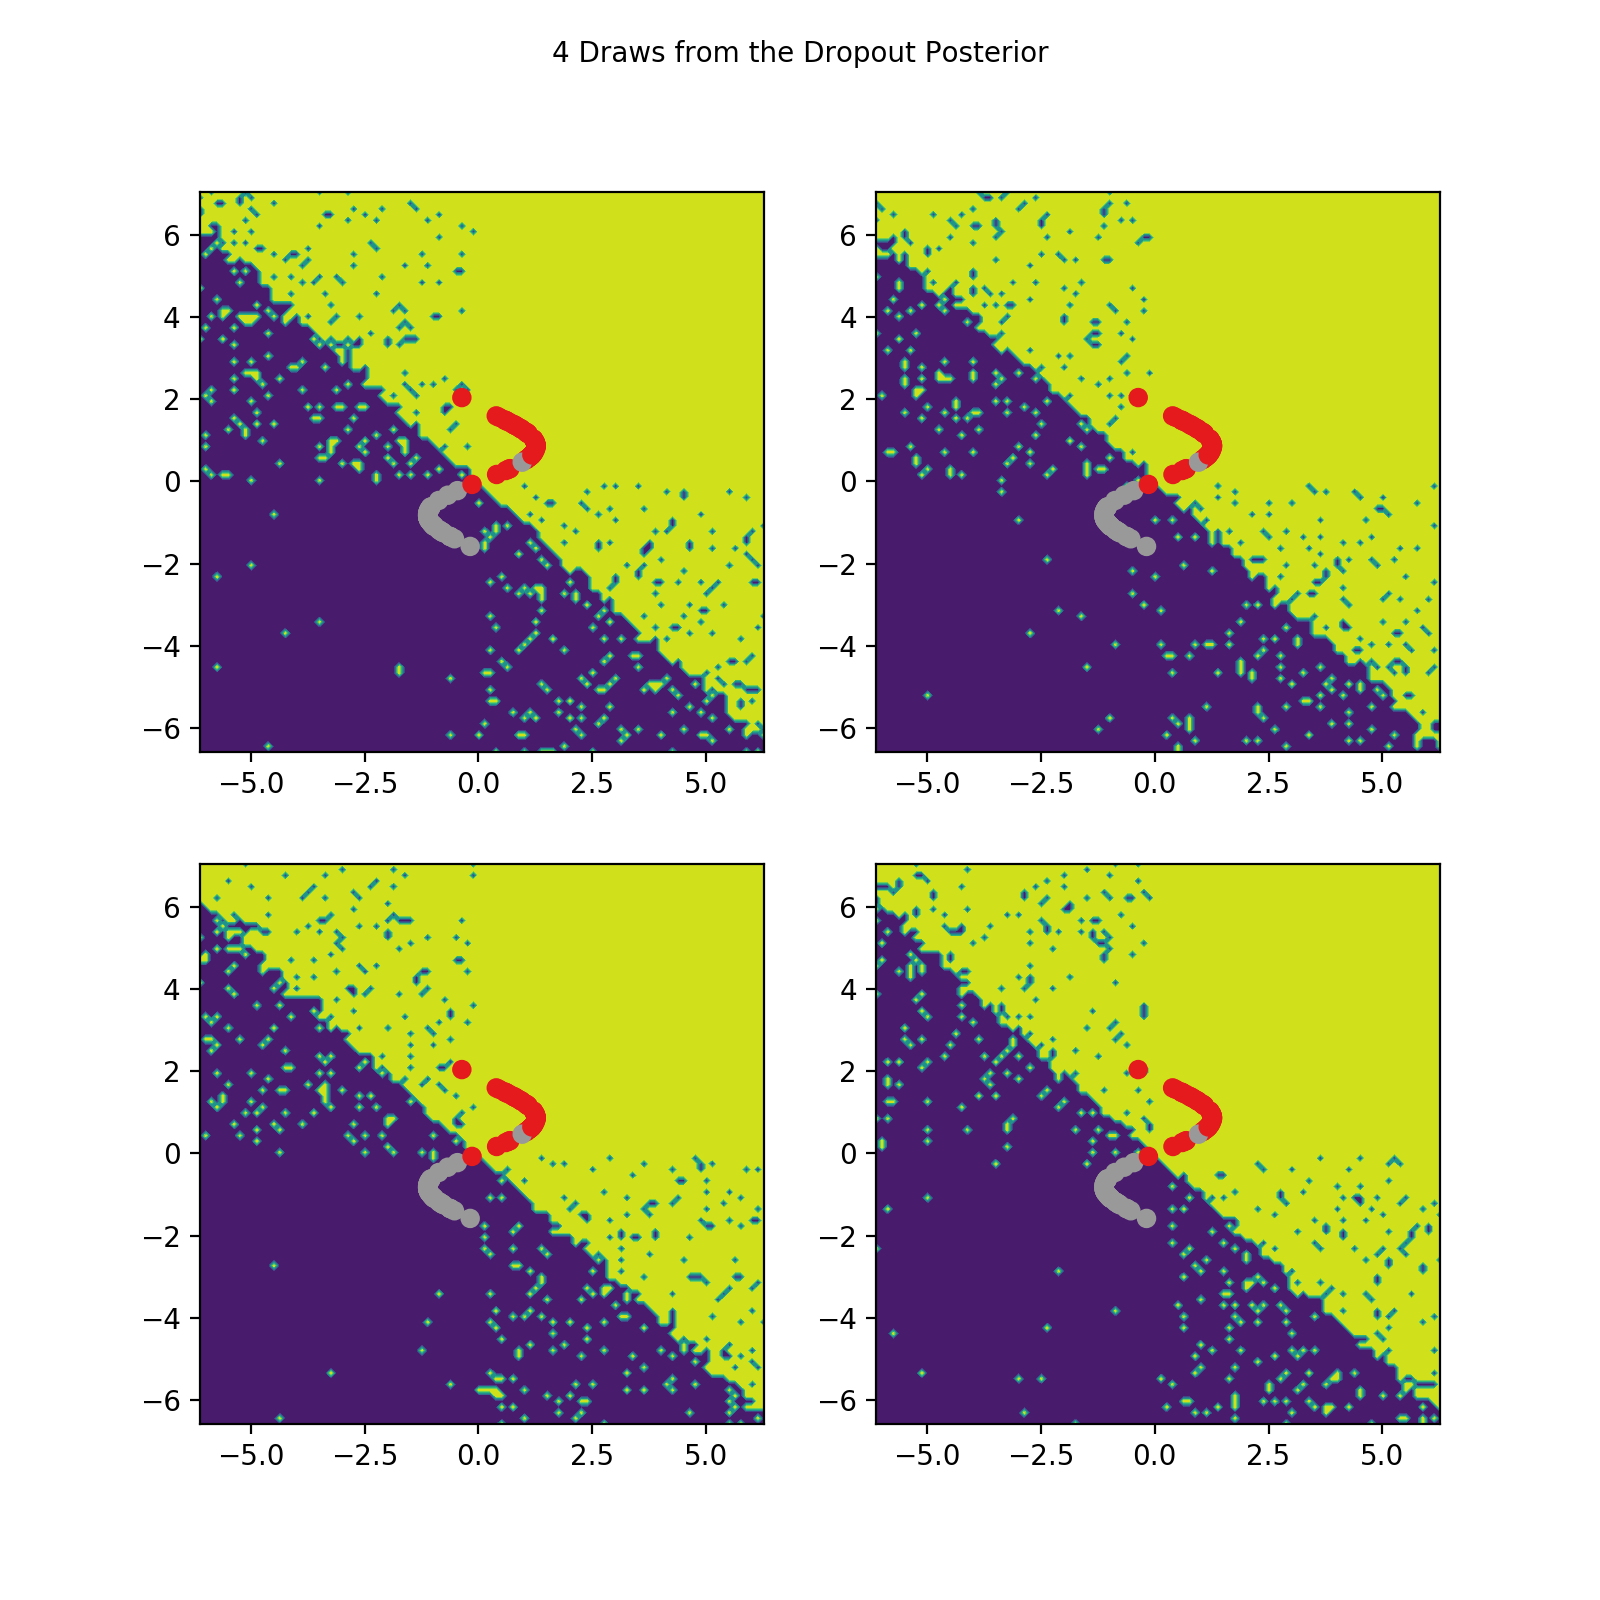

Text(0.5,0.975,'4 Draws from the Dropout Posterior')

In [47]:
preds = [model.predict(plot_x).argmax(axis=1).reshape(xx.shape) for _ in range(4)]
f, ax = plt.subplots(2,2)
for (a, p) in zip(ax.flatten(), preds):
    a.contourf(xx,yy,p)
    a.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.Set1_r)
f.text(0.5, 0.975, '4 Draws from the Dropout Posterior',
         horizontalalignment='center', verticalalignment='top')

**Remark:** Is the very rough posterior induced by dropout desirable? 

<IPython.core.display.Javascript object>


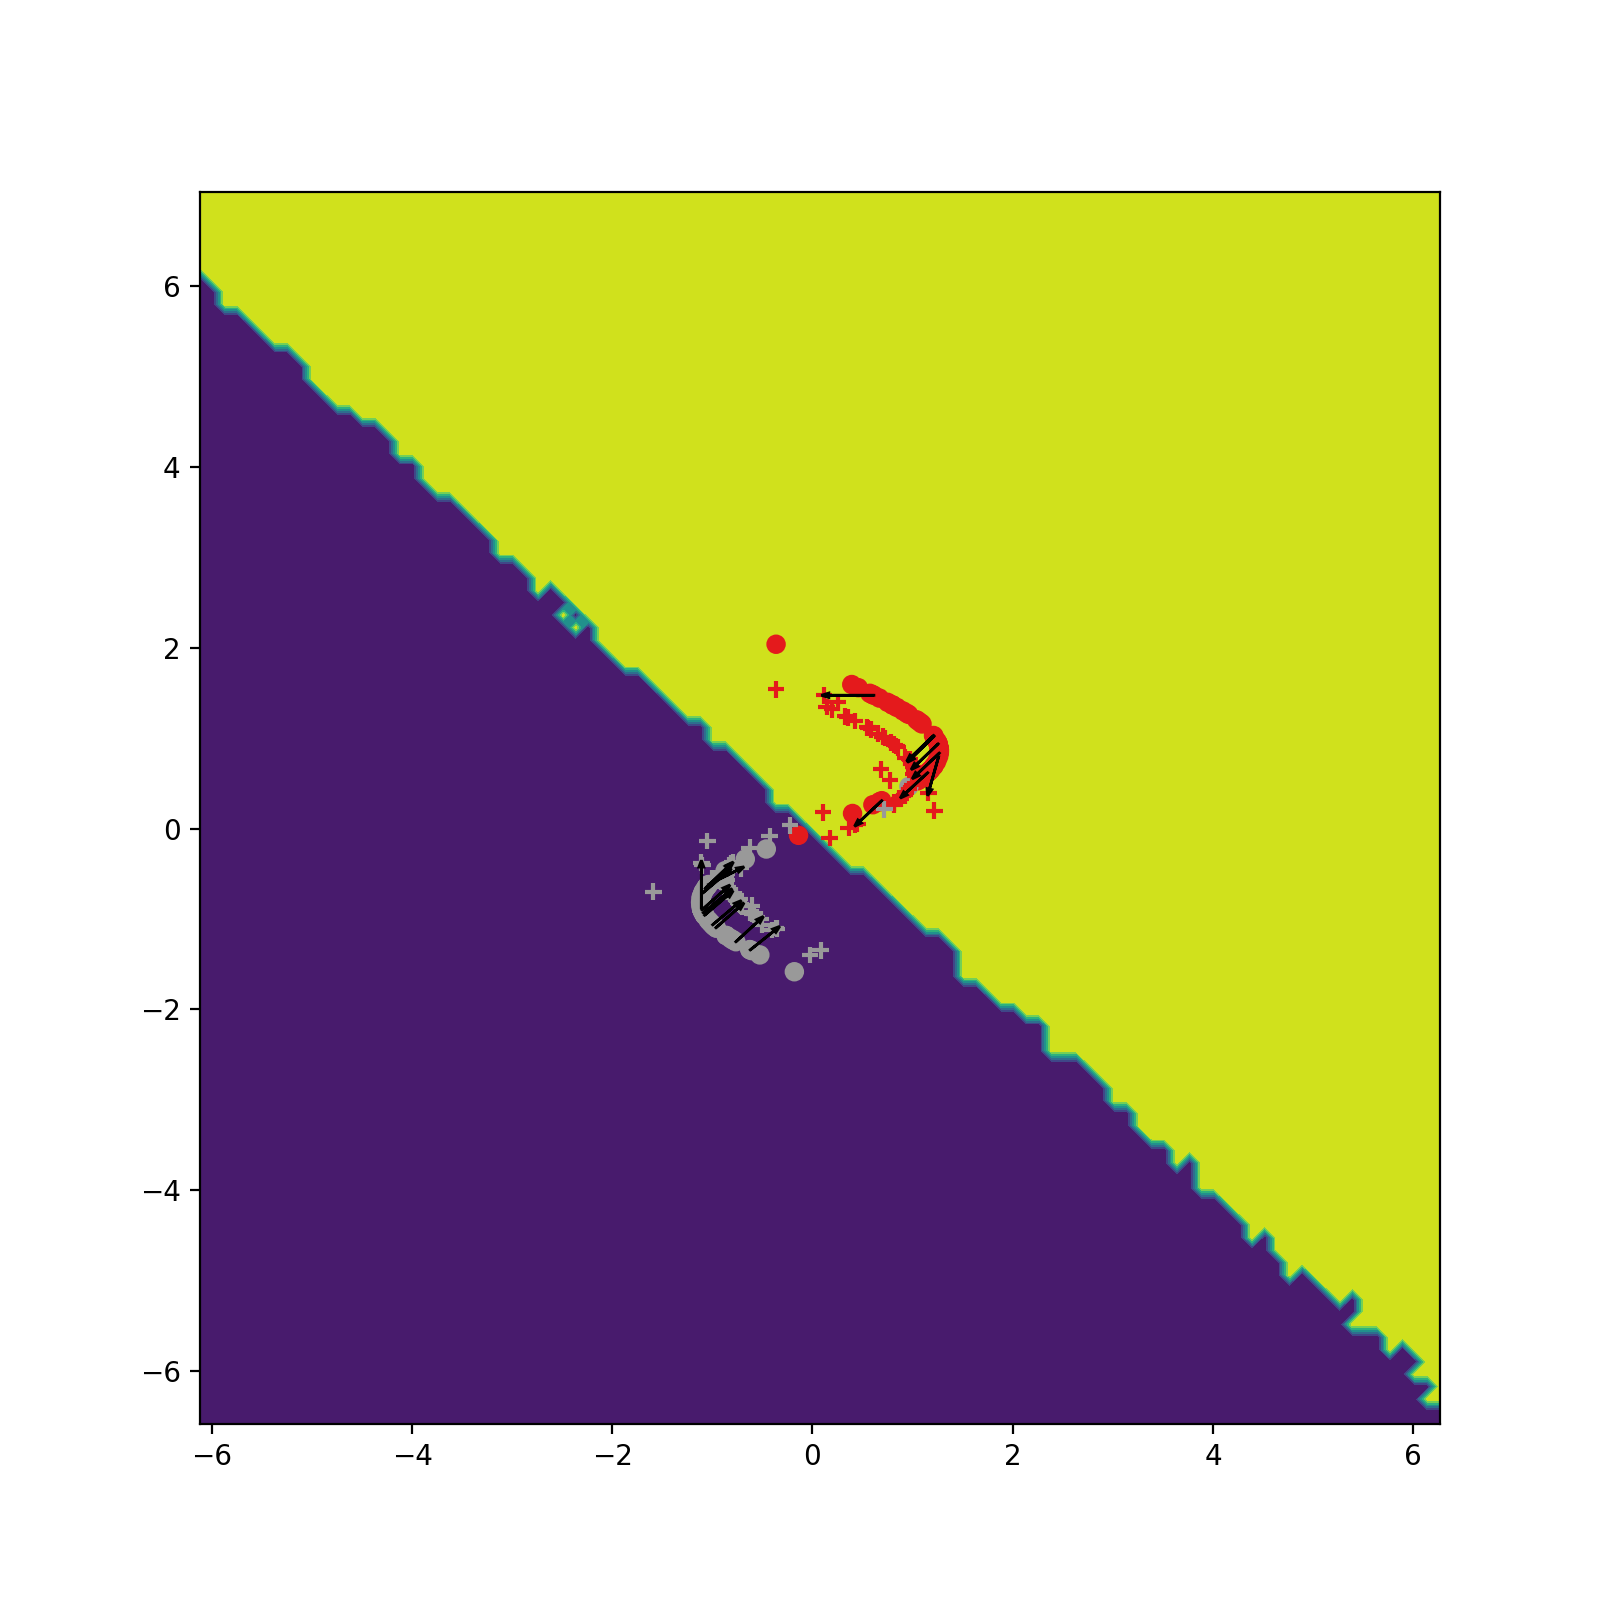

In [48]:
adv = fgm(inputs, predictions, eps = 0.5, ord = 1)
adv_points = adv.eval(session=K.get_session(),feed_dict={inputs: x})
plt.figure()
plt.contourf(xx,yy,plot_preds )
plt.scatter(data[:,0],data[:,1], c=labels , cmap=plt.cm.Set1_r); plt.show()

#draw some example arrows
for i in range(20):
    plt.arrow(data[i,0],data[i,1],
              (adv_points[i,0] - data[i,0]) * .9,
              (adv_points[i,1] - data[i,1]) * .9,
              head_width=0.05, fc='k')

plt.scatter(adv_points[:,0], adv_points[:,1], c=labels, marker='+',cmap=plt.cm.Set1_r); plt.show()

In the plots above and below, one can vary the choice of norms optimised by the method. This is equivalent to choosing our definition of what it means for an example to be 'adversarial'; we would say roughly that it is a point in X that is close to a correctly classified point x but is misclassified by our model. Making this a more formal statement requires choosing a norm to define 'closeness' with.
        

<IPython.core.display.Javascript object>


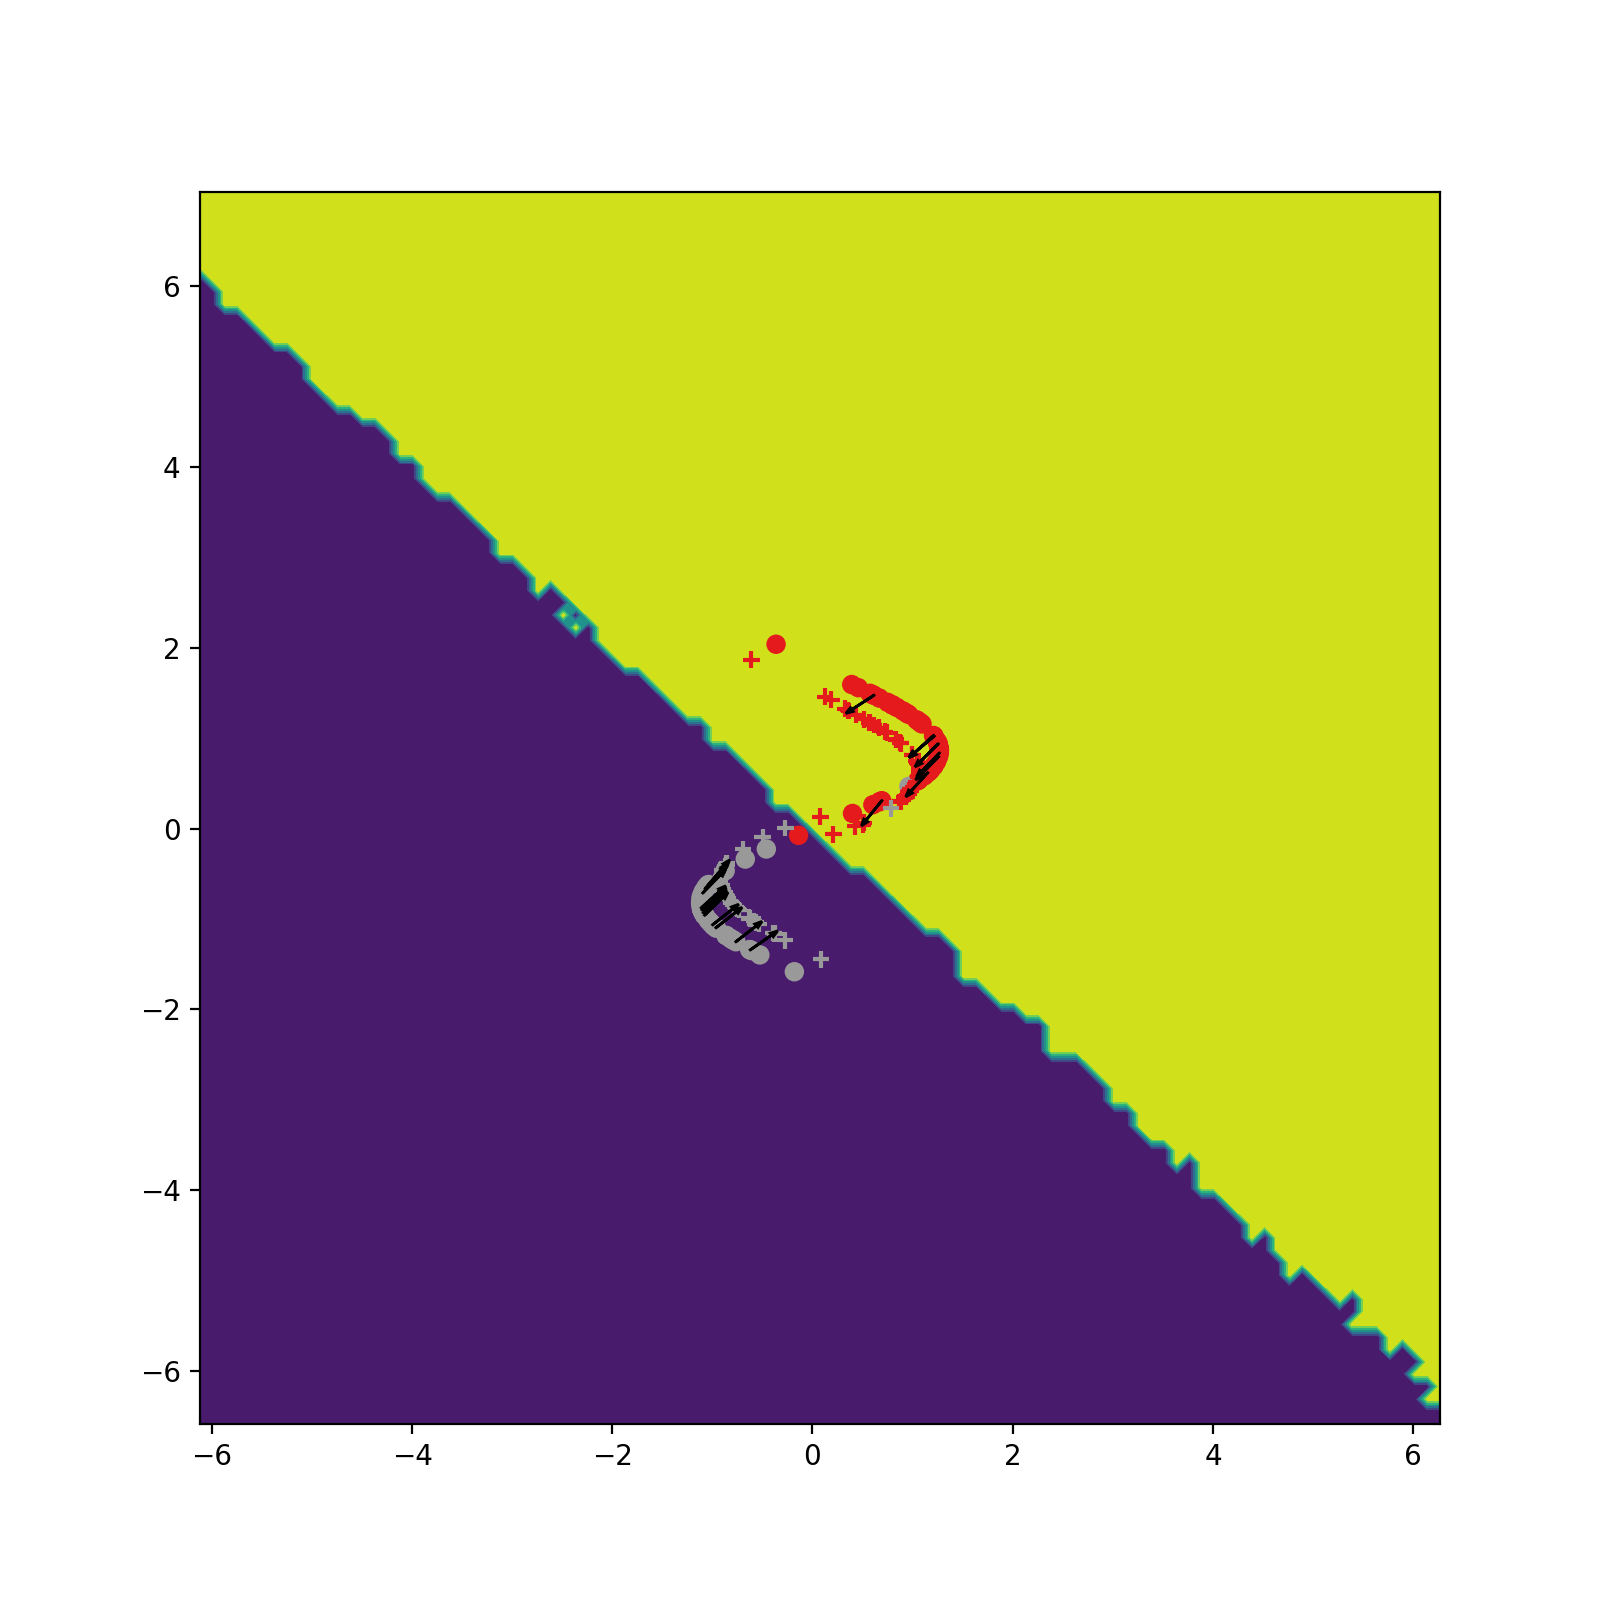

0.98999999999999999

In [49]:
#some messing around to get cleverhans to play with the mc model. Since this isn't implemented as a keras layer (yet?)
#some jiggery-pokery needs to be done so it looks like one enough to satisfy cleverhans' required interface.
from cleverhans.model import CallableModelWrapper
from cleverhans.attacks import BasicIterativeMethod
x = data
y = labels
def mc_model(x):
    #model is captured by closure.
    mc_preds_tensor = mc_dropout_preds(model, x, n_mc=n_mc)
    mean_preds = K.mean(mc_preds_tensor, axis=0)
    return mean_preds

wrapper = CallableModelWrapper(mc_model,'probs')
bim = BasicIterativeMethod(wrapper, sess=K.get_session())
adv = bim.generate(inputs, eps=.3, eps_iter = 0.1, nb_iter=10, ord=2)

adv_points = adv.eval(session=K.get_session(), feed_dict={inputs: x})

plt.figure()
plt.contourf(xx,yy,plot_preds )
plt.scatter(data[:,0],data[:,1], c=labels , cmap=plt.cm.Set1_r); plt.show()

#draw some example arrows
for i in range(20):
    plt.arrow(data[i,0],data[i,1],
              (adv_points[i,0] - data[i,0]) * .9,
              (adv_points[i,1] - data[i,1]) * .9,
              head_width=0.05, fc='k')

plt.scatter(adv_points[:,0], adv_points[:,1], c=labels, marker='+',cmap=plt.cm.Set1_r); plt.show()
sum(model.predict(adv_points).argmax(axis=1) == labels) / 100

In [50]:
#compare above plots to a GP classifier

import GPy as gp

kernel =gp.kern.MLP(2)
lik = gp.likelihoods.Bernoulli()
gp_model = gp.core.GP(X=data,
                      Y=labels.reshape(-1,1),
                      kernel=kernel,
                      inference_method=gp.inference.latent_function_inference.laplace.Laplace(),
                      likelihood=lik)
#optimise hyperparameters
print(gp_model)
for i in range(2):
    gp_model.optimize('bfgs', max_iters=100)
    print("iter:",i,gp_model)




Name : gp
Objective : 14.772325828563709
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                  |  value  |  constraints  |  priors
  mlp.variance         |    1.0  |      +ve      |        
  mlp.weight_variance  |    1.0  |      +ve      |        
  mlp.bias_variance    |    1.0  |      +ve      |        
iter: 0 
Name : gp
Objective : 8.331096756795379
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                  |               value  |  constraints  |  priors
  mlp.variance         |       99141.2818166  |      +ve      |        
  mlp.weight_variance  |   7.77629297529e-05  |      +ve      |        
  mlp.bias_variance    |  5.56268464627e-309  |      +ve      |        
iter: 1 
Name : gp
Objective : 8.331095879936056
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                  |               value  |  constraints  |  p

 /anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


<IPython.core.display.Javascript object>


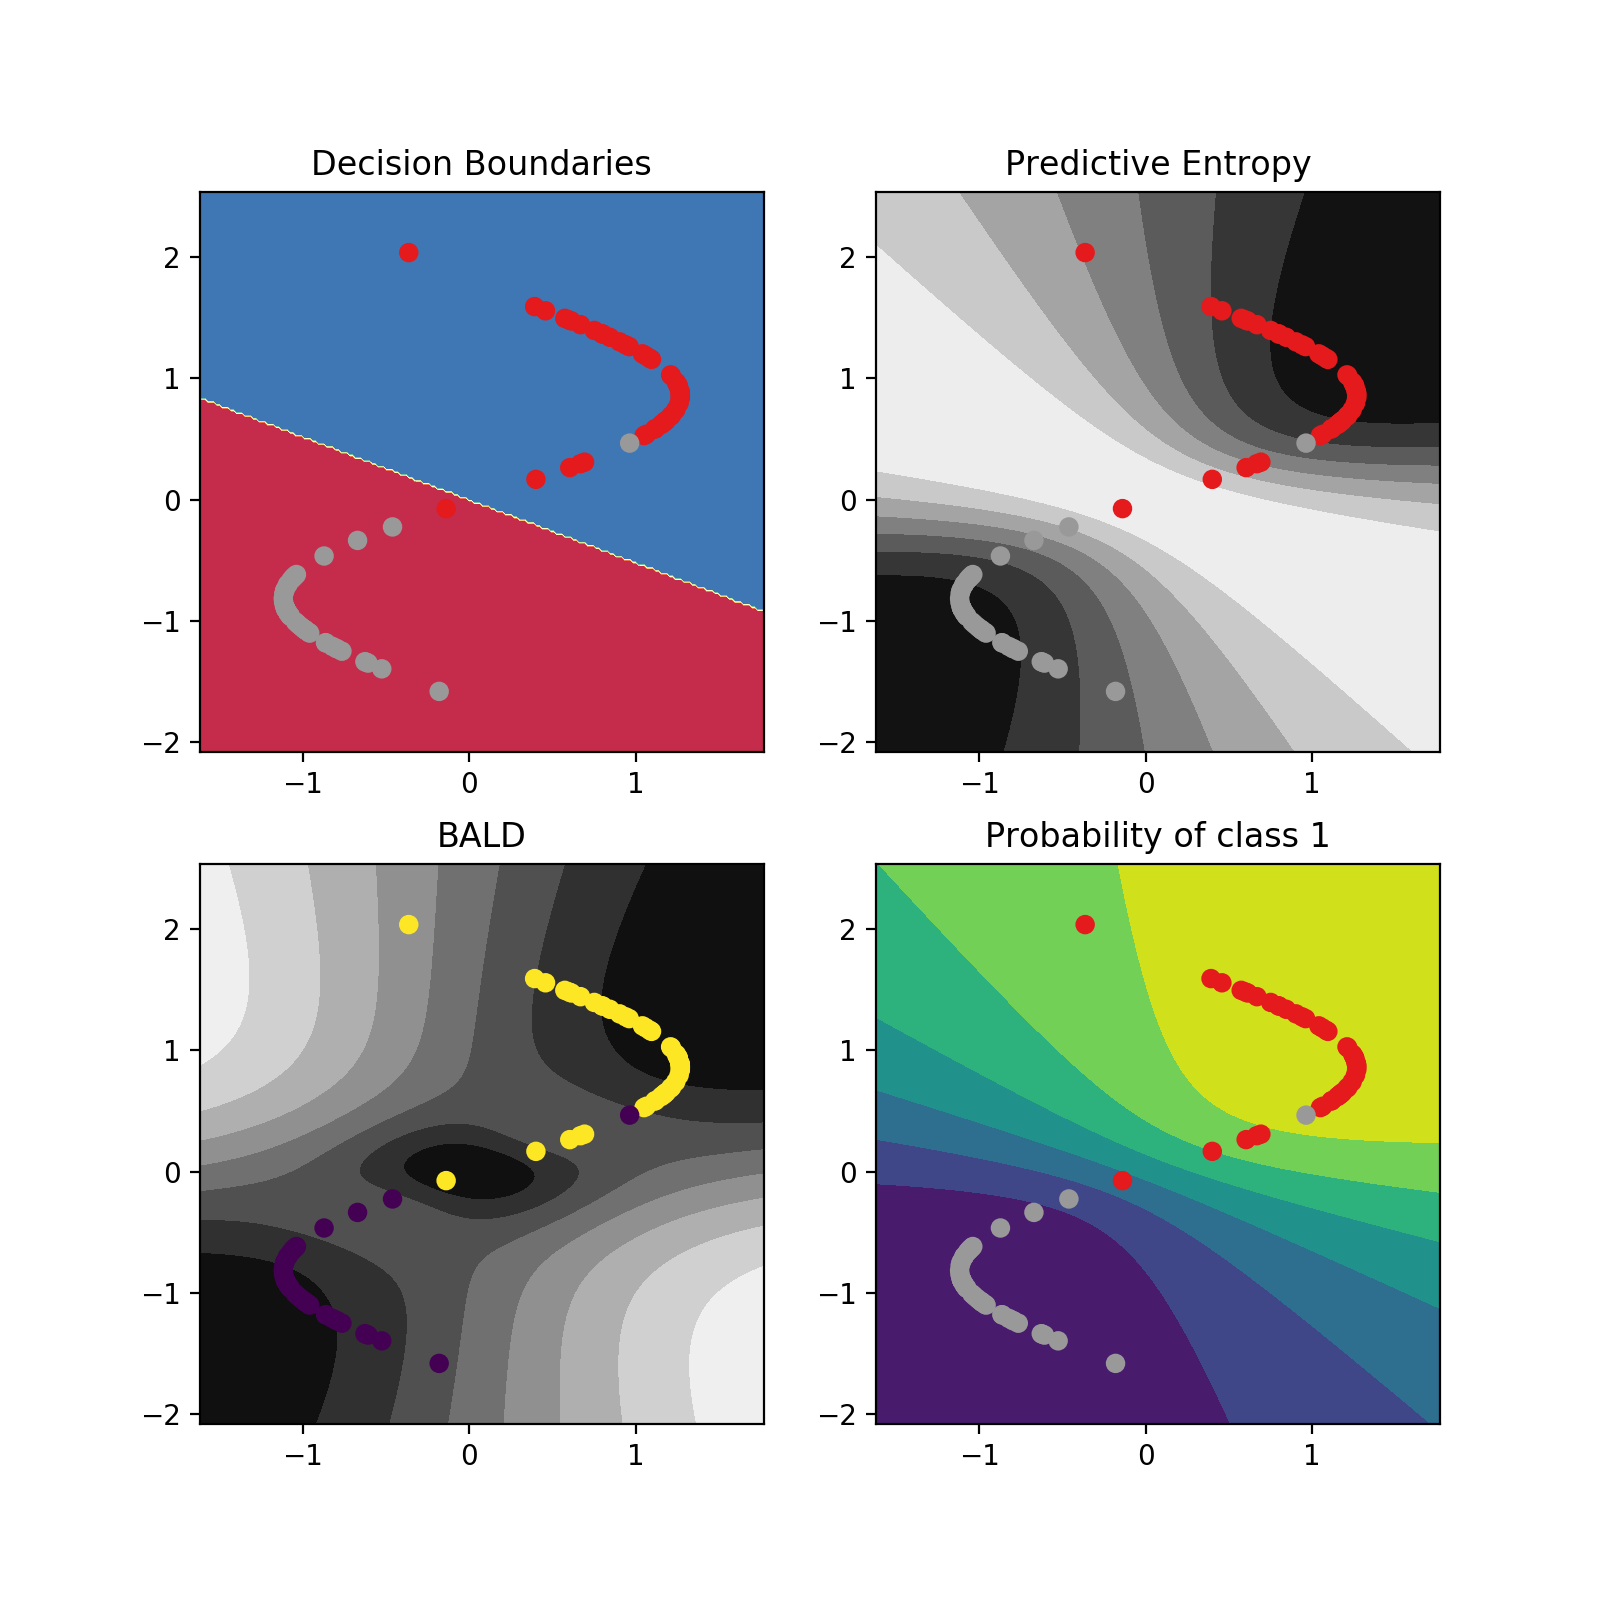

In [51]:

xx,yy = np.meshgrid(np.linspace(data[:,0].min() -.5,data[:,0].max() + .5, 200),
                    np.linspace(data[:,1].min()-.5,data[:,1].max()+.5, 200))
plot_x = np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1)
plot_probs,_ = gp_model.predict(plot_x)
f, ax = plt.subplots(2,2)
axlist = [x for x in ax.flatten()]

axlist[0].contourf(xx, yy, np.reshape(plot_probs > .5, xx.shape), cmap = plt.cm.Spectral)
axlist[0].scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.Set1_r)
axlist[0].set_title('Decision Boundaries')

axlist[3].contourf(xx,yy,plot_probs.reshape(xx.shape))
axlist[3].scatter(data[:,0], data[:,1], c = labels, cmap=plt.cm.Set1_r)
axlist[3].set_title('Probability of class 1')

entropy = - (plot_probs * np.log(plot_probs) + (1 - plot_probs) * np.log(1 - plot_probs))
#todo: make this a bit nicer.

axlist[1].contourf(xx,yy,entropy.reshape(xx.shape), cmap = 'gray')
axlist[1].scatter(data[:,0], data[:,1], c = labels, cmap=plt.cm.Set1_r)
axlist[1].set_title('Predictive Entropy')

#calculate the BALD for a GP; see Neil Houslby's thesis, section 3.2 
# https://www.repository.cam.ac.uk/bitstream/handle/1810/248885/HoulsbyThesis.pdf
l_m, l_v = gp_model.predict(plot_x, include_likelihood=False) #mean and variance of latent function
#approximate E(H(p(y|theta)))
C = np.sqrt(np.pi * np.log(2) /2)
expect_H = (1 / np.log2(np.e))  * C / (np.sqrt(l_v + C**2)) * np.exp( - l_m ** 2 / ( 2 * l_v + C**2))
bald = entropy - expect_H

axlist[2].contourf(xx,yy,bald.reshape(xx.shape), cmap = 'gray')
axlist[2].scatter(data[:,0], data[:,1], c = labels)
axlist[2].set_title('BALD')
plt.show()

Here, I plot analogous quantities for a GP with the 'neural network' kernel. The correspondece is not exact (the 'MLP' kernel corresponds to the limit of a single hidden layer neural network with (bounded) logistic activations and Gaussian priors over the weights. The uncertainty estimates here are qualitatively similar to those above, though the GP is more uncertain, as might be expected. Interestingly, using a non-stationary kernel by default leads to generalisation; this is probably desirable, but leads to the GP also generally failing to predict whether datapoints are on the low dimensional manifold the data was generated on. The thing I think that is potentially interesting abount this is I wonder if it suggests that some non-stationary kernels can't be rescued from confident off-manifold predictions by a bayesian treatment alone; here we are integrating over the weights but there are regions where the models is very confident even though these datapoints have zero support under the generating distribution. (e.g at 2,2).